In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression # modelos lineales
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluación
from sklearn import datasets, metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [38]:
col_Headers = ["EventType","RegisterDate","StopID","Odometer","Longitude","Latitude", "TaskID","LineID","TripID","DatagramID","DatagramTimestamp","BusID"]
missing_values = ["n/a", "na", "--", "NaT","%WARN%"]
df = pd.read_csv('m_datagrams.csv',',',dtype={"EventType": str, "RegisterDate": str, "StopID": str,"Odometer": str,"Longitude": str,"Latitude": str, "TaskID": str,"LineID": str,"TripID": str,"DatagramID": str,"DatagramTimestamp": str,"BusID": str},names = col_Headers, na_values = missing_values)

In [39]:
df['DatagramTimestamp']= pd.to_datetime(df['DatagramTimestamp']) 
df['DatagramDate'] = pd.to_datetime(df['DatagramTimestamp']).dt.date
df['DatagramTime'] = pd.to_datetime(df['DatagramTimestamp']).dt.time
df = df.drop('DatagramTimestamp',1)
col_Headers = ["EventType","RegisterDate","StopID","Odometer","Longitude","Latitude", "TaskID","LineID","TripID","DatagramID","DatagramDate","DatagramTime","BusID"]
df = df[col_Headers]

## Analisis Exploratorio de Datos

Un análisis exploratorio de los datos verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

In [40]:
df.head()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
0,19,2018-09-04,501051,1,-764871900,34451717,572,140,548,5661359158,2018-09-03,07:05:57,714
1,19,2018-09-04,502103,1063,-765463867,33977717,1023,217,882,5661362653,2018-09-03,07:07:19,311
2,7,2018-09-04,515152,24,-765076783,34191300,705,2471,43,5661362655,2018-09-03,07:07:19,796
3,19,2018-09-04,502650,788,-764913067,34220317,143,150,389,5661367800,2018-09-03,07:09:21,561
4,7,2018-09-04,515006,91,-765005167,34115933,705,2471,43,5661348896,2018-09-03,07:01:54,796


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242473 entries, 0 to 2242472
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   EventType     object
 1   RegisterDate  object
 2   StopID        object
 3   Odometer      object
 4   Longitude     object
 5   Latitude      object
 6   TaskID        object
 7   LineID        object
 8   TripID        object
 9   DatagramID    object
 10  DatagramDate  object
 11  DatagramTime  object
 12  BusID         object
dtypes: object(13)
memory usage: 222.4+ MB


In [42]:
data_missing= df.isnull().sum()/len(df)*100
data_missing

EventType        0.000000
RegisterDate    31.830350
StopID           0.000089
Odometer         0.000089
Longitude        0.000089
Latitude         0.000089
TaskID           0.000089
LineID           0.000089
TripID           0.000089
DatagramID       0.000089
DatagramDate    32.079494
DatagramTime    32.079494
BusID            0.000089
dtype: float64

In [43]:
df.tail()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
2242468,8,2018-06-29,502301,-1,-765284850,34415983,145,2104,165,5511316915,2018-06-28,15:44:47,30
2242469,5,2018-06-29,502551,597,-765102900,34897600,931,2274,491,5511337393,2018-06-28,15:54:22,69
2242470,8,2018-06-29,502551,597,-1,-1,931,2274,491,5511337432,2018-06-28,15:54:23,69
2242471,WARN: The method class org.apache.commons.logg...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2242472,WARN: Please see http://www.slf4j.org/codes.ht...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


### Missing Values

Standard Type = NaN,"", "%WARN%"


Estos son los missing values reconocidos en el Dataset

#### Los -1 y los 0 son buses que van sin tarea, sin operación, son viajes de posicionamiento o de salida

In [44]:
print("Porcentajes de -1 por cada columna : ")
i=0
for a in df.columns:
  print(a,":",(df[a].values=='-1').sum()/len(df)*100,"%")
  i+=1

Porcentajes de -1 por cada columna : 
EventType : 0.0 %
RegisterDate : 0.0 %
StopID : 3.487667410042395 %
Odometer : 23.387394184902117 %
Longitude : 3.420464817190664 %
Latitude : 3.420464817190664 %
TaskID : 2.7919176730332986 %
LineID : 2.3678768930551226 %
TripID : 2.8771806840037764 %
DatagramID : 0.0 %
DatagramDate : 0.0 %
DatagramTime : 0.0 %
BusID : 0.0 %


In [45]:
df.describe(include="all")

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
count,2242473,1528686,2242471,2242471,2242471,2242471,2242471,2242471,2242471,2242471,1523099,1523099,2242471
unique,34,243,2120,12571,65753,108930,4304,111,2798,2242471,242,75959,853
top,7,2019-03-30,-1,-1,-1,-1,-1,2273,-1,5663735417,2019-03-14,07:14:58,147
freq,320439,11502,78210,524456,76703,76703,62608,101770,64520,1,12400,64,52793


In [46]:
df2= df[(df['EventType']=='12') | (df['EventType']=='23')]
df2.head()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
7,23,2018-09-04,500106,63,-765076683,34882767,1005,421,577,5661355791,2018-09-03,07:04:39,883
12,23,2018-09-04,502601,-1,-764863567,34130200,161,150,45,5661347319,2018-09-03,07:01:17,571
14,23,2018-09-04,513038,40,-765037383,34749833,579,3372,285,5661355907,2018-09-03,07:04:41,156
66,23,2018-09-07,515048,163,-765000800,34115600,2698,2473,99999,5667035023,2018-09-06,07:39:55,158
76,23,2018-09-05,511274,38,-765228500,33838717,76,2211,343,5664051200,2018-09-04,08:32:15,156


In [47]:
temp= df2.BusID.value_counts().to_frame()
BusIDCounts= temp.reset_index()
BusIDCounts.columns=['BusID','Counts']
BusIDCounts.head()

,BusID,Counts
0,255,11341
1,640,10900
2,571,8264
3,153,7349
4,150,6925


In [48]:
plt.rc('figure',figsize=(15,8))

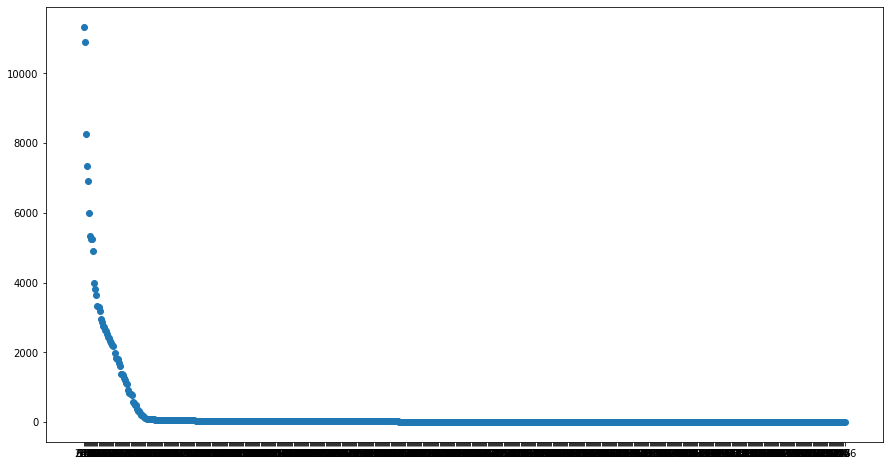

In [49]:
x = BusIDCounts['BusID']
y = BusIDCounts['Counts']

fig, ax = plt.subplots()
ax.scatter(x,y)
plt.show()

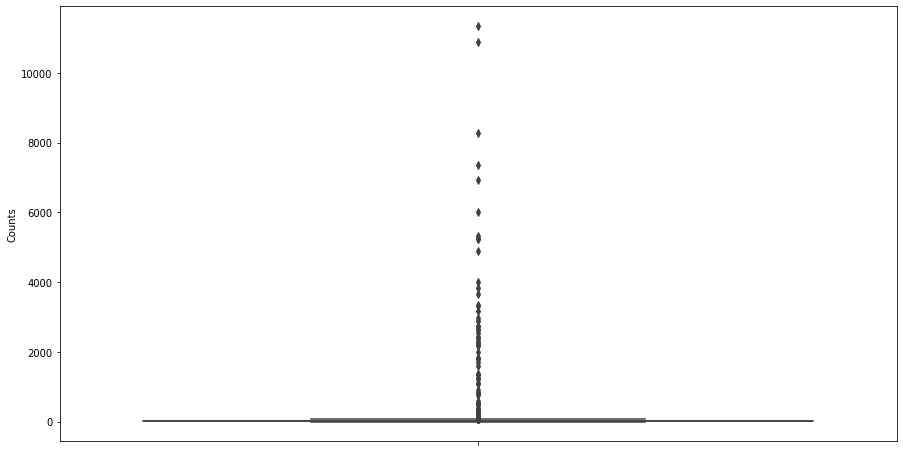

In [50]:
sns.boxplot(y=BusIDCounts['Counts'])

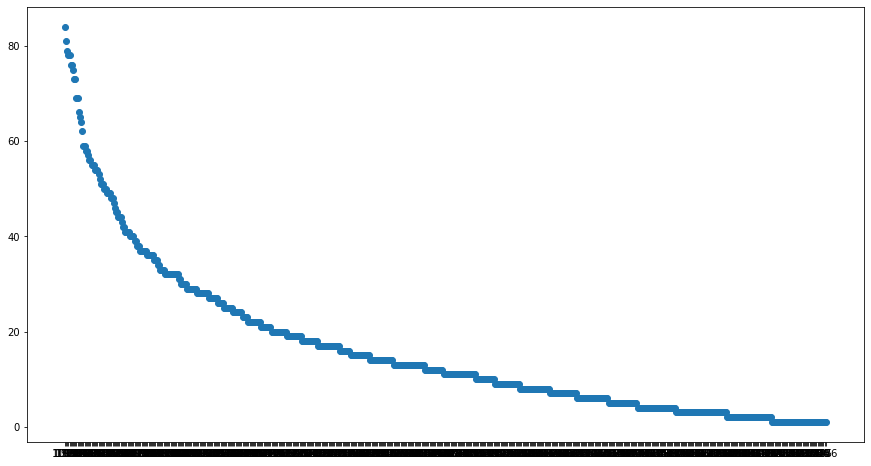

In [51]:
BusIDCounts2 = BusIDCounts[BusIDCounts['Counts'] < 100]
x2 = BusIDCounts2['BusID']
y2 = BusIDCounts2['Counts']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
plt.show()


In [52]:
df.dropna()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
0,19,2018-09-04,501051,1,-764871900,34451717,572,140,548,5661359158,2018-09-03,07:05:57,714
1,19,2018-09-04,502103,1063,-765463867,33977717,1023,217,882,5661362653,2018-09-03,07:07:19,311
2,7,2018-09-04,515152,24,-765076783,34191300,705,2471,43,5661362655,2018-09-03,07:07:19,796
3,19,2018-09-04,502650,788,-764913067,34220317,143,150,389,5661367800,2018-09-03,07:09:21,561
4,7,2018-09-04,515006,91,-765005167,34115933,705,2471,43,5661348896,2018-09-03,07:01:54,796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242466,23,2018-06-30,519289,89,-765455650,34505950,455,305,251,5511392911,2018-06-30,05:46:36,151
2242467,7,2018-06-29,514055,-1,-764770883,34390933,716,142,164,5511313442,2018-06-28,15:43:08,261
2242468,8,2018-06-29,502301,-1,-765284850,34415983,145,2104,165,5511316915,2018-06-28,15:44:47,30
2242469,5,2018-06-29,502551,597,-765102900,34897600,931,2274,491,5511337393,2018-06-28,15:54:22,69


In [53]:
duplicateDFRow = df[df.duplicated()]
print(duplicateDFRow)

Empty DataFrame
Columns: [EventType, RegisterDate, StopID, Odometer, Longitude, Latitude, TaskID, LineID, TripID, DatagramID, DatagramDate, DatagramTime, BusID]
Index: []


In [54]:
df2 = df[(df['EventType']=='12') | (df['EventType']=='23')]
df2.head()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
7,23,2018-09-04,500106,63,-765076683,34882767,1005,421,577,5661355791,2018-09-03,07:04:39,883
12,23,2018-09-04,502601,-1,-764863567,34130200,161,150,45,5661347319,2018-09-03,07:01:17,571
14,23,2018-09-04,513038,40,-765037383,34749833,579,3372,285,5661355907,2018-09-03,07:04:41,156
66,23,2018-09-07,515048,163,-765000800,34115600,2698,2473,99999,5667035023,2018-09-06,07:39:55,158
76,23,2018-09-05,511274,38,-765228500,33838717,76,2211,343,5664051200,2018-09-04,08:32:15,156


In [55]:
temp= df2.BusID.value_counts().to_frame()
BusIDCounts= temp.reset_index()
BusIDCounts.columns=['BusID','Counts']
BusIDCounts2 = BusIDCounts[BusIDCounts['Counts'] < 100]
BusIDCounts2.head()

,BusID,Counts
59,1107,84
60,1065,81
61,1170,79
62,1171,78
63,960,78


# Buses selected to graph

### Bus Id: 1107
### Bus Id: 1065
### Bus Id: 1170


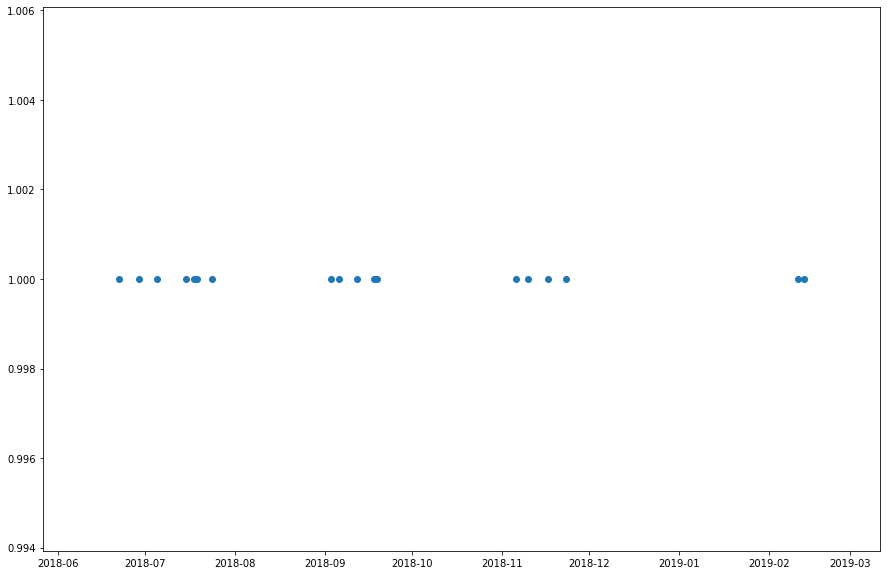

In [107]:
dfBus1 = df2[(df2['BusID'] == '1107')]
dfBus1_1 = dfBus1['DatagramDate'].drop_duplicates().to_frame()
dfBus1_1 = dfBus1_1.drop(268454)
size = dfBus1_1.size
plt.rc('figure',figsize=(15,10))
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus1_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
plt.show()

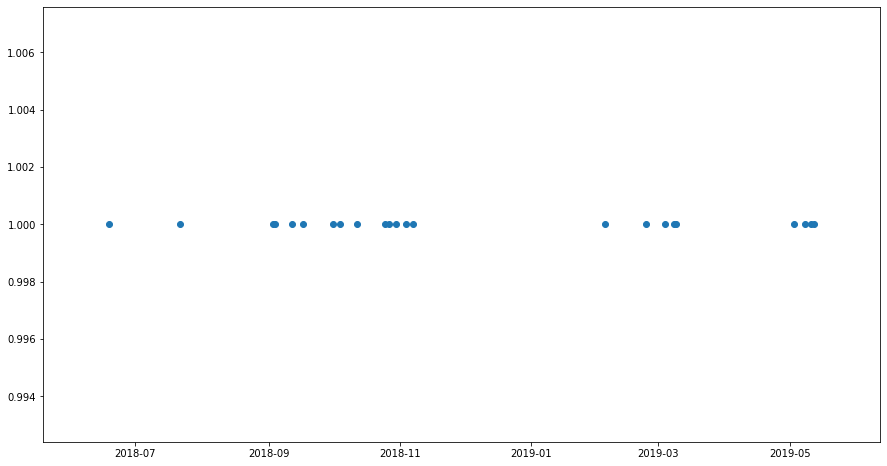

In [105]:
dfBus2 = df2[(df2['BusID'] == '1065')]
dfBus2_1 = dfBus2['DatagramDate'].drop_duplicates().to_frame()
dfBus2_1 = dfBus2_1.drop(969811)
size = dfBus2_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus2_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
plt.show()

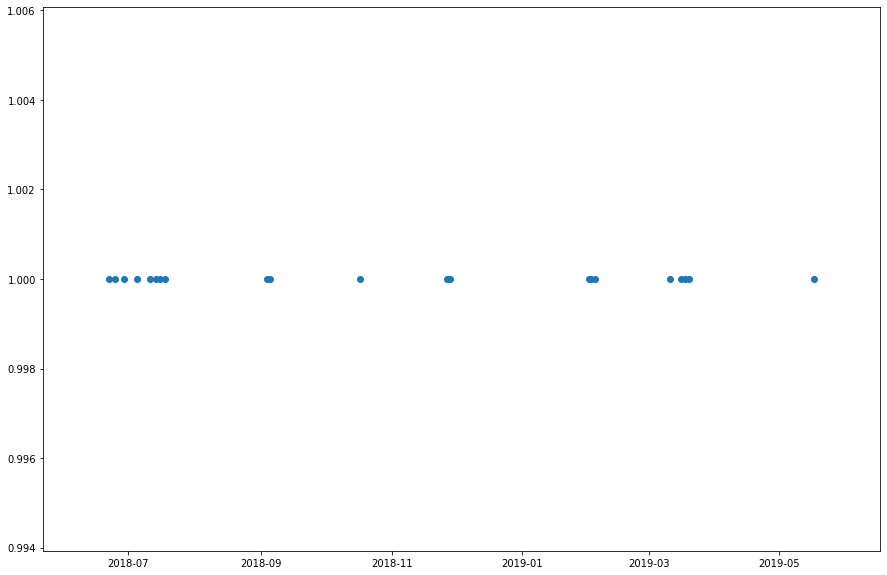

In [111]:
dfBus3 = df2[(df2['BusID'] == '1170')]
dfBus3_1 = dfBus3['DatagramDate'].drop_duplicates().to_frame()
dfBus3_1 = dfBus3_1.drop(1008189)
size = dfBus3_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus3_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
plt.show()

In [143]:
dfBus4 = df2[(df2['BusID'] == '255')]
dfBus4_1 = dfBus4['DatagramDate'].drop_duplicates().to_frame()
size = dfBus4_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus4_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
plt.show()

ConversionError: Failed to convert value(s) to axis units: 226        2018-09-04
314        2018-09-06
998        2018-09-03
2938       2018-09-05
4226       2018-09-13
              ...    
1265296    2019-03-30
1324716    2019-02-03
1786814    2019-03-26
1964193    2018-11-18
2076550    2018-06-11
Name: DatagramDate, Length: 220, dtype: object